In [30]:
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from tqdm import tqdm
from predict import *
from HGGEP_HGNN import *
from dataset import ViT_HER2ST, ViT_SKIN
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

# Data Loading

In [31]:
name=[*[f'A{i}' for i in range(2,7)],*[f'B{i}' for i in range(1,7)],
      *[f'C{i}' for i in range(1,7)],*[f'D{i}' for i in range(1,7)],
      *[f'E{i}' for i in range(1,4)],*[f'F{i}' for i in range(1,4)],*[f'G{i}' for i in range(1,4)]]
patients = ['P2', 'P5', 'P9', 'P10']
reps = ['rep1', 'rep2', 'rep3']
skinname = []
for i in patients:
    for j in reps:
        skinname.append(i+'_ST_'+j)
device='cuda'
tag='5-7-2-8-4-16-32'
k,p,d1,d2,d3,h,c=map(lambda x:int(x),tag.split('-'))
dropout=0.2
random.seed(12000)
np.random.seed(12000)
torch.manual_seed(12000)
torch.cuda.manual_seed(12000)
torch.cuda.manual_seed_all(12000)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# HGGEP Prediction

In [32]:
fold=12
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

In [5]:
testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
genes=785
model=HGGEP(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5,
)
model.load_state_dict(torch.load(f'./model/HGGEP/{fold}-Hist2ST.ckpt'))
pred, gt = test(model, test_loader,'cuda')

te_names: ['F1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


In [6]:
R=get_R(pred,gt)[0]
print('Pearson Correlation:',np.nanmean(R))

Pearson Correlation: 0.1122036904738274


# Predict Top Gene: 

In [7]:
def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

model.load_state_dict(torch.load(f'./model/HGGEP/{fold}-Hist2ST.ckpt'))
adata_pred, adata_truth = test(model, test_loader)
adata_pred = comp_tsne_km(adata_pred,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g
# print(len(g), g[:10]) # 785 gene
sc.pp.scale(adata_pred)
sc.pp.scale(adata_truth)
print(adata_pred, adata_truth)

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


AnnData object with n_obs × n_vars = 691 × 785
    obs: 'kmeans'
    var: 'mean', 'std'
    uns: 'pca', 'tsne'
    obsm: 'spatial', 'X_pca', 'X_tsne'
    varm: 'PCs' AnnData object with n_obs × n_vars = 691 × 785
    var: 'mean', 'std'
    obsm: 'spatial'


In [8]:
adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
# list(adata_pre.columns)

In [10]:
def get_PCC(adata_pre, adata_true):
    gene_names = adata_pre.columns

    result_df = pd.DataFrame(index=['PCC', 'PV', '-log10_PV'], columns=gene_names)

    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [corr_coef, p_value, -np.log10(p_value)]

    result_df = result_df.T

    result_df_sorted = result_df.sort_values(by='PCC', ascending=False)

    return result_df_sorted

get_PCC(adata_pre, adata_true)

,PCC,PV,-log10_PV
IGKC,0.710980,1.873444e-107,106.727359
IGLC2,0.426681,6.066996e-32,31.217026
FASN,0.402307,2.878096e-28,27.540895
SCD,0.387770,3.244230e-26,25.488888
IGHG3,0.384035,1.051743e-25,24.978090
...,...,...,...
ANGPTL4,-0.035125,3.565669e-01,0.447859
CHST11,-0.046866,2.185400e-01,0.660469
TCEA3,-0.050173,1.877281e-01,0.726471
SCX,-0.062263,1.019823e-01,0.991475


In [9]:
# get the value
from scipy.stats import pearsonr

genes = ['GNAS', 'UBA52', 'MUCL1']
for gene in genes:
    gene_true = adata_true[gene]
    gene_pre = adata_pre[gene]
    # FASN_true.shape

    pearson_corrcoef, p_value = pearsonr(gene_true, gene_pre)
    # print('Pearson Correlation:',np.nanmean(R))
    print(gene, pearson_corrcoef)

# MYL12B
# 8 0.6207262018691467
# GNAS
# 7 0.5906530987577501
# FASN
# 14 0.510873127279465
# SCD
# 10 0.6103439096566053

GNAS 0.34341222025864626
UBA52 0.13513815851744454
MUCL1 0.09126696780269167


Predict gene expression:

In [ ]:
Gene_show = 'GNAS'  # ['GNAS', 'UBA52', 'MUCL1']

model.load_state_dict(torch.load(f'./model/HGGEP/{fold}-Hist2ST.ckpt'))
# device = torch.device('cpu')
# dataset = ViT_HER2ST(train=False,sr=False,fold=fold)
# test_loader = DataLoader(dataset, batch_size=1, num_workers=4)
adata_pred, adata_truth = test(model, test_loader)
adata_pred = comp_tsne_km(adata_pred,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g

# Create the spatial plot
sc.pl.spatial(adata_pred, img=None, color=Gene_show, spot_size=150, color_map='magma', show=False)

# Save the figure with a pure white background and high resolution (e.g., 300 dpi)
# plt.savefig('./figures/spatial_plot.png', dpi=600, facecolor='white')
plt.savefig('./figures/5_spatial_'+str(Gene_show)+'.pdf')

# If you want to display the plot as well
plt.show()

In [ ]:
# sc.pl.spatial(pred, img=None, color='kmeans', spot_size=112)

import matplotlib.pyplot as plt
img_path = './data/her2st/data/ST-imgs/B/B1/BT10737_C1_HE.jpg'
img_data = plt.imread(img_path)
# print(pred.shape, pred[0][:10])
sc.pl.spatial(pred, img=img_data, color='kmeans', spot_size=112)
sc.pl.spatial(gt, img=img_data, color='kmeans', spot_size=112)

sc.pl.spatial(adata_pred, img=None, color='FASN', spot_size=112, color_map='magma')

In [ ]:
sc.pl.spatial(pred, img=None, color='kmeans', spot_size=112)

# Top 10 Prediction

In [ ]:
folds=[]

# from HIST2ST import *
from HIST2ST_Baseline import *
# from HIST2ST_HGNN import *
for i in range(32):
    folds.append(i)
# print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

Hist2ST_results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    model=HGGEP(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    # model.load_state_dict(torch.load(f'./model/her2st/'+str(fold)+'-HGGEP.ckpt'))
    model.load_state_dict(torch.load(f'./model/her2st_official/'+str(fold)+'-Hist2ST.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    Hist2ST_results_all.append(res)


In [ ]:
from scipy.stats import pearsonr

# genes = ['GNAS', 'UBA52', 'MUCL1']
genes = genes = ['MYL12B', 'GNAS', 'FASN', 'SCD']
for gene in genes:
    print(gene)
    PCC_best, fold_best = 0, 0
    for fold in folds:
        pearson_corrcoef = Hist2ST_results_all[fold].loc[gene]
        PCC_value = pearson_corrcoef.loc['PCC']
        if PCC_value > PCC_best:
            PCC_best = PCC_value
            fold_best = fold
    print(fold_best, PCC_best)

MYL12B
8 0.6207262018691467
GNAS
7 0.5906530987577501
FASN
14 0.510873127279465
SCD
10 0.6103439096566053


# Figure 5

In [ ]:
Gene_show = 'GNAS'  # ['GNAS', 'UBA52', 'MUCL1']

img_path = './data/her2st/data/ST-imgs/B/B3/BT10737_D1_HE.jpg'
img_data = plt.imread(img_path)

model.load_state_dict(torch.load(f'./model/her2st/{fold}-Hist2ST.ckpt'))
# device = torch.device('cpu')
# dataset = ViT_HER2ST(train=False,sr=False,fold=fold)
# test_loader = DataLoader(dataset, batch_size=1, num_workers=4)
adata_pred, adata_truth = test(model, test_loader)
adata_pred = comp_tsne_km(adata_pred,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g

# Create the spatial plot
sc.pl.spatial(adata_pred, img=None, color=Gene_show, spot_size=150, color_map='magma', show=False)

# Save the figure with a pure white background and high resolution (e.g., 300 dpi)
plt.savefig('./figures/spatial_plot.pdf')

# If you want to display the plot as well
plt.show()

# Figure 5 : HGGEP

In [20]:
folds=[]

from HGGEP_HGNN import *
for i in range(32):
    folds.append(i)
# print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    gene_names = adata_pre.columns
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    result_df = result_df.T

    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

HGGEP_results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    model=HGGEP(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/her2st/{fold}-Hist2ST.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    HGGEP_results_all.append(res)


te_names: ['A2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


te_names: ['A3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


te_names: ['A4']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


te_names: ['A5']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


te_names: ['A6']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


te_names: ['B1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


te_names: ['B2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


te_names: ['B3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


te_names: ['B4']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


te_names: ['B5']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


te_names: ['B6']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


te_names: ['C1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


te_names: ['C2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


te_names: ['C3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


te_names: ['C4']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


te_names: ['C5']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


te_names: ['C6']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


te_names: ['D1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


te_names: ['D2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


te_names: ['D3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


te_names: ['D4']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


te_names: ['D5']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


te_names: ['D6']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


te_names: ['E1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


te_names: ['E2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


te_names: ['E3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


te_names: ['F1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


te_names: ['F2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


te_names: ['F3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


te_names: ['G1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


te_names: ['G2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


te_names: ['G3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


In [23]:
from scipy.stats import pearsonr

genes = ['MYL12B', 'GNAS', 'FASN', 'SCD']
for gene in genes:
    print(gene)
    PCC_best, fold_best = 0, 0
    for fold in folds:
        pearson_corrcoef = HGGEP_results_all[fold].loc[gene]
        PCC_value = pearson_corrcoef.loc['PCC']
        if PCC_value > PCC_best:
            PCC_best = PCC_value
            fold_best = fold
    print(fold_best, PCC_best)

MYL12B
9 0.6516888665834257
GNAS
7 0.6371508417594052
FASN
16 0.5637526702753419
SCD
10 0.6495225608741068


te_names: ['B4']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


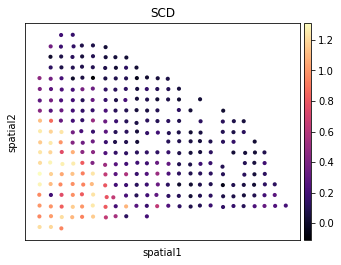

: 

In [36]:
import cv2
from HGGEP_HGNN import *

Gene_show = 'SCD'  # ['MYL12B', 'GNAS', 'FASN', 'SCD']
fold = 8  # 7 or 22 for FASN
model_fold = 10

# img_path = './data/her2st/data/ST-imgs/B/B3/BT10737_D1_HE.jpg'
# img_path = './data/her2st/data/ST-imgs/D/D6/10426_HE_BT_E2.jpg'
# img_path = './data/her2st/data/ST-imgs/B/B4/BT10737_D2_HE.jpg'
# img_data = plt.imread(img_path)

# gray_img = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)

# save_path = './figures/Img5_gray_'+Gene_show+'.pdf'
# cv2.imwrite(save_path, gray_img)

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    gene_names = adata_pre.columns

    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    result_df = result_df.T

    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
testset = pk_load(fold,'test',dataset='her2st',flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
model=HGGEP(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
model.load_state_dict(torch.load(f'model/her2st/'+str(model_fold)+'-HGGEP.ckpt'))

adata_pred, adata_truth = test(model, test_loader)
adata_pred = comp_tsne_km(adata_pred,4)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g

# sc.pl.spatial(adata_pred, img=None, color=Gene_show, spot_size=112, color_map='magma')
sc.pl.spatial(adata_pred, img=None, color=Gene_show, spot_size=112, color_map='magma', show=False)

# Save the figure with a pure white background and high resolution (e.g., 300 dpi)
plt.savefig('./figures/Fig5_spatial_'+Gene_show+'.pdf')

# If you want to display the plot as well
plt.show()

# Figure 4

In [13]:
# import cv2
from HGGEP_HGNN import *
from predict import *

fold = 30
resolution = 0.1

# img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/G/G2/HE_BT23903_C2a.jpg'
# img_data = plt.imread(img_path)

# gray_img = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)

# save_path = './figures/ARI_image_gray_'+str(fold)+'.png'
# cv2.imwrite(save_path, gray_img)

def comp_tsne_leiden(adata, resolution=1.0):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    
    # Compute neighborhood graph
    sc.pp.neighbors(adata)
    
    # Use Scanpy's Leiden clustering
    sc.tl.leiden(adata, key_added='leiden', resolution=resolution)
    
    adata.obs['leiden'] = adata.obs['leiden'].astype(str)
    
    return adata

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    gene_names = adata_pre.columns
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    result_df = result_df.T

    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
testset = pk_load(fold,'test',dataset='her2st',flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
model=HGGEP(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5,
)
ARI_best, model_fold = 0, 0
for i in range(32):
    model.load_state_dict(torch.load(f'./model/her2st/'+str(i)+'-HGGEP.ckpt'))

    adata_pred, adata_truth = test(model, test_loader)

    clus,ARI=cluster(adata_pred,label,method='leiden', resolution=resolution)
    print(i, 'ARI:',ARI)
    if ARI>ARI_best:
        model_fold = i
        ARI_best = ARI
print('ARI_best:',ARI_best, model_fold)

# model_fold = 17
model.load_state_dict(torch.load(f'./model/her2st/'+str(model_fold)+'-HGGEP.ckpt'))

adata_pred, adata_truth = test(model, test_loader)

clus,ARI=cluster(adata_pred,label,method='leiden', resolution=resolution)  
# 5: kmeans : ARI: 0.174, leiden : ARI: 0.112
# 17: kmeans : ARI: 0.271, leiden : ARI: 0.121
print('ARI:',ARI)

# adata_pred = comp_tsne_km(adata_pred,3)
adata_pred = comp_tsne_leiden(adata_pred, resolution=resolution)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g

plt.gcf().set_facecolor('white')

sc.pl.spatial(adata_pred, img=None, color='leiden', spot_size=112, show=False)
# sc.pl.spatial(adata_pred, img=None, color='kmeans', spot_size=112, show=False) 

plt.savefig('./figures/Fig6_ARI_'+str(fold)+'.pdf')

plt.show()

te_names: ['G2']
Loading imgs...
Loading metadata...


TypeError: new() received an invalid combination of arguments - got (list, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!list!, !int!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


te_names: ['G2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Leiden
0 ARI: 0.155


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


Leiden
1 ARI: 0.137


100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


Leiden
2 ARI: 0.233


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


Leiden
3 ARI: 0.219


100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


Leiden
4 ARI: 0.22


100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


Leiden
5 ARI: 0.198


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Leiden
6 ARI: 0.121


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


Leiden
7 ARI: 0.179


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


Leiden
8 ARI: 0.182


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Leiden
9 ARI: 0.21


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Leiden
10 ARI: 0.165


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Leiden
11 ARI: 0.215


100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


Leiden
12 ARI: 0.185


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


Leiden
13 ARI: 0.233


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Leiden
14 ARI: 0.168


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


Leiden
15 ARI: 0.239


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


Leiden
16 ARI: 0.197


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Leiden
17 ARI: 0.152


100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Leiden
18 ARI: 0.183


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Leiden
19 ARI: 0.23


100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


Leiden
20 ARI: 0.173


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


Leiden
21 ARI: 0.197


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Leiden
22 ARI: 0.182


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


Leiden
23 ARI: 0.138


100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


Leiden
24 ARI: 0.199


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Leiden
25 ARI: 0.206


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


Leiden
26 ARI: 0.166


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


Leiden
27 ARI: 0.166


100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Leiden
28 ARI: 0.237


100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


Leiden
29 ARI: 0.206


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Leiden
30 ARI: 0.091


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Leiden
31 ARI: 0.188
ARI_best: 0.239 15


100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


Leiden
ARI: 0.239


<Figure size 432x288 with 0 Axes>

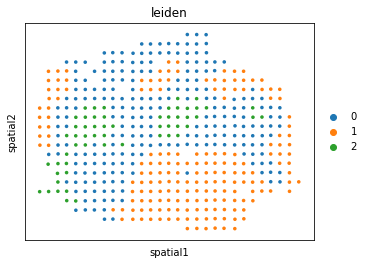

In [36]:
# For Hist2ST 

from HIST2ST_Baseline import *
from predict import *

fold = 30
resolution = 0.1

# get gray image

# img_path = '/home/zy/libo/Hist2ST/data/her2st/data/ST-imgs/G/G2/HE_BT23903_C2a.jpg'
# img_data = plt.imread(img_path)

# gray_img = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)

# save_path = './figures/ARI_image_gray_'+str(fold)+'.png'
# cv2.imwrite(save_path, gray_img)

def comp_tsne_leiden(adata, resolution=1.0):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    
    # Compute neighborhood graph
    sc.pp.neighbors(adata)
    
    # Use Scanpy's Leiden clustering
    sc.tl.leiden(adata, key_added='leiden', resolution=resolution)
    
    adata.obs['leiden'] = adata.obs['leiden'].astype(str)
    
    return adata

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

gene_names = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
testset = pk_load(fold,'test',dataset='her2st',flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
model=Hist2ST(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5,
)
ARI_best, model_fold = 0, 0
for i in range(32):
    model.load_state_dict(torch.load(f'/media/zy/MyPassport/UF/her2st_official/'+str(i)+'-Hist2ST.ckpt'))

    adata_pred, adata_truth = test(model, test_loader)

    clus,ARI=cluster(adata_pred,label,method='leiden', resolution=resolution)
    print(i, 'ARI:',ARI)
    if ARI>ARI_best:
        model_fold = i
        ARI_best = ARI
print('ARI_best:',ARI_best, model_fold)

# model_fold = 17
model.load_state_dict(torch.load(f'/media/zy/MyPassport/UF/her2st_official/'+str(model_fold)+'-Hist2ST.ckpt'))

adata_pred, adata_truth = test(model, test_loader)

clus,ARI=cluster(adata_pred,label,method='leiden', resolution=resolution)  
# 5: kmeans : ARI: 0.174, leiden : ARI: 0.112
# 17: kmeans : ARI: 0.271, leiden : ARI: 0.121, 权衡参数，
print('ARI:',ARI)

# adata_pred = comp_tsne_km(adata_pred,3)
adata_pred = comp_tsne_leiden(adata_pred, resolution=resolution)

g = list(np.load('data/her_hvg_cut_1000.npy',allow_pickle=True))
adata_pred.var_names = g
adata_truth.var_names = g

plt.gcf().set_facecolor('white')

sc.pl.spatial(adata_pred, img=None, color='leiden', spot_size=112, show=False)
# sc.pl.spatial(adata_pred, img=None, color='kmeans', spot_size=112, show=False) 

plt.savefig('./figures/Fig6_ARI_'+str(fold)+'.png', dpi=600, facecolor='white')

plt.show()